In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pybiodynamics import (
    Species, Parameter, SystemModel, MassActionReaction,
    simulate_ode, run_gillespie_simulation, plot_simulation_results
)

This code implements the classic **Lotka-Volterra predator-prey model**. The interactions between the two species are described by a set of coupled ordinary differential equations.

---
### The Equations

The dynamics of the prey population, $x$, and the predator population, $y$, are given by:

1.  **Prey Equation:** $\frac{dx}{dt} = c_1 x - c_2 xy$
2.  **Predator Equation:** $\frac{dy}{dt} = c_2 xy - c_3 y$

---
### Explanation of Terms & Coefficients

* **$x$**: The population size of the **prey**.
* **$y$**: The population size of the **predator**.

#### Prey Dynamics ($\frac{dx}{dt}$)
* $c_1 x$: This term represents the **growth of the prey population**. In the absence of predators, the prey population grows exponentially at a rate of $c_1$. This corresponds to the `prey_birth` reaction.
* $-c_2 xy$: This term represents the **loss of prey due to predation**. The rate of loss is proportional to the rate at which predators and prey meet, which depends on both populations ($x$ and $y$). This corresponds to the `predation` reaction.

#### Predator Dynamics ($\frac{dy}{dt}$)
* $c_2 xy$: This term represents the **growth of the predator population** from consuming prey. It is also proportional to the encounter rate between the species. This corresponds to the `predator_birth` reaction.
* $-c_3 y$: This term represents the **natural death of predators**. In the absence of prey to eat, the predator population dies off exponentially at a rate of $c_3$. This corresponds to the `predator_death` reaction.


#### Parameter choice

We choose the parameters as Dan Gillespie did in his famous algorithm paper

In [5]:
model = SystemModel("Predator-Prey")

# Define species with initial conditions
prey = Species('x', initial_condition=1000.0, positive=True)
predator = Species('y', initial_condition=1000.0, positive=True)

# Define parameters
prey_birth_rate = Parameter('c1', default_value=10, positive=True)
predation_rate = Parameter('c2', default_value=0.01, positive=True)
predator_death_rate = Parameter('c3', default_value=10, positive=True)

# Add species and parameters to model
model.add_species(prey) \
        .add_species(predator) \
        .add_parameter(prey_birth_rate) \
        .add_parameter(predation_rate) \
        .add_parameter(predator_death_rate)

# Define reactions
# 1. Prey birth: x -> 2x (rate = c1 * x)
prey_birth = MassActionReaction(
    name='prey_birth', 
    reactants={prey: 1}, 
    products={prey: 2}, 
    rate=prey_birth_rate
)

# 2. Predation: x + y -> y (rate = c2 * x * y)
predation = MassActionReaction(
    name='predation',
    reactants={prey: 1, predator: 1},
    products={predator: 1},
    rate=predation_rate
)

# 3. Predator birth: x + y -> x + 2y (rate = c2 * x * y)
predator_birth = MassActionReaction(
    name='predator_birth',
    reactants={prey: 1, predator: 1},
    products={prey: 1, predator: 2},
    rate=predation_rate
)

# 4. Predator death: y -> 0 (rate = c3 * y)
predator_death = MassActionReaction(
    name='predator_death',
    reactants={predator: 1},
    products={},
    rate=predator_death_rate
)

# Add reactions to model
model.add_reaction(prey_birth) \
        .add_reaction(predation) \
        .add_reaction(predator_birth) \
        .add_reaction(predator_death)


SystemModel(name='Predator-Prey', species=2, parameters=3, reactions=4)

#### We can easily simulate the model as a set of ODEs

we can display the ODE system we have defined

In [6]:
model.display_latex_odes()

<IPython.core.display.Latex object>

and even display the parameter values we defined:

In [7]:
model.display_latex_odes_with_values()

<IPython.core.display.Latex object>

We can simulate the system. This set of parameter values does not lead to very interesting dynamics:

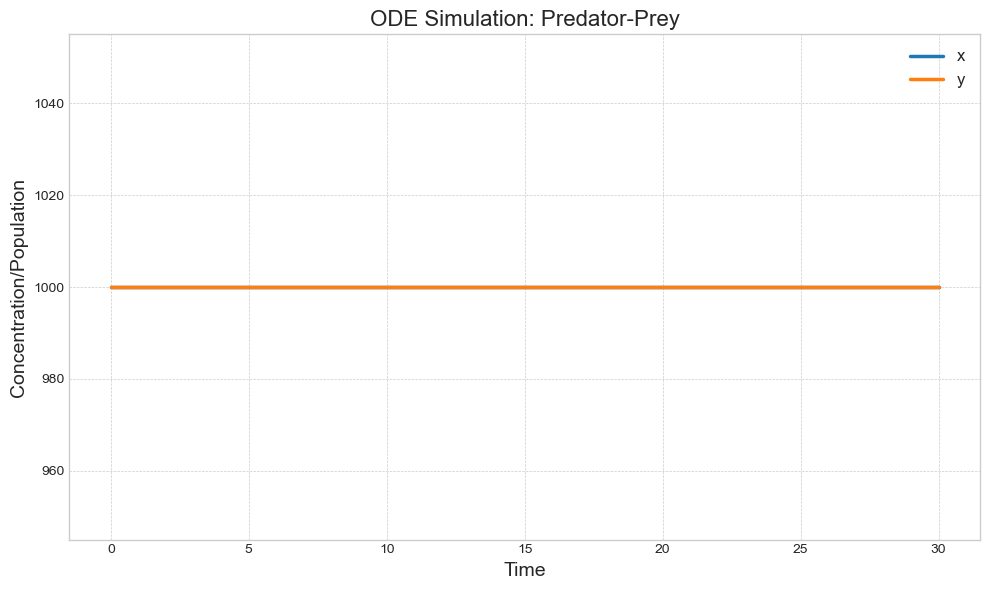

In [8]:
# Set up simulation parameters
t_span = [0, 30]  # Time from 0 to 30
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Run simulation
result = simulate_ode(model, t_span, t_eval)


plot_simulation_results(result, result_type='ode', 
                        title=f"ODE Simulation: {model.name}")



#### We can also think of our system in terms of propensity functions, which allows us to do stochastic simulations:

We can look at each propensity function (essentially a set of reactions) and the corresponding stoichiometry matrix

In [9]:
model.generate_propensity_vector()

Matrix([
[  c1*x],
[c2*x*y],
[c2*x*y],
[  c3*y]])

In [10]:
model.generate_stoichiometric_matrix()

array([[ 1, -1,  0,  0],
       [ 0,  0,  1, -1]])

We can therefore multiply these together to recover the deterministic system

In [11]:
model.generate_stoichiometric_matrix() * model.generate_propensity_vector()

Matrix([
[c1*x - c2*x*y],
[c2*x*y - c3*y]])

Let's simulate our system using Gillespie! 

In [ ]:
results = run_gillespie_simulation(
    model, 
    tmax=25, 
    use_numba=False, 
    seed=42,  
    plot=True
)


Running Gillespie simulation until t = 25...


The Gillespie simulation can also be compiled with Numba to improve performance

Running Gillespie simulation until t = 25...
Simulation completed in 8661.08 ms

Simulation Statistics:
+-------------+------------------+----------------------+
| Component   |   Gillespie Mean |   Gillespie Variance |
|-------------+------------------+----------------------|
| x           |          999.886 |               411273 |
| y           |         1003.75  |               404199 |
+-------------+------------------+----------------------+


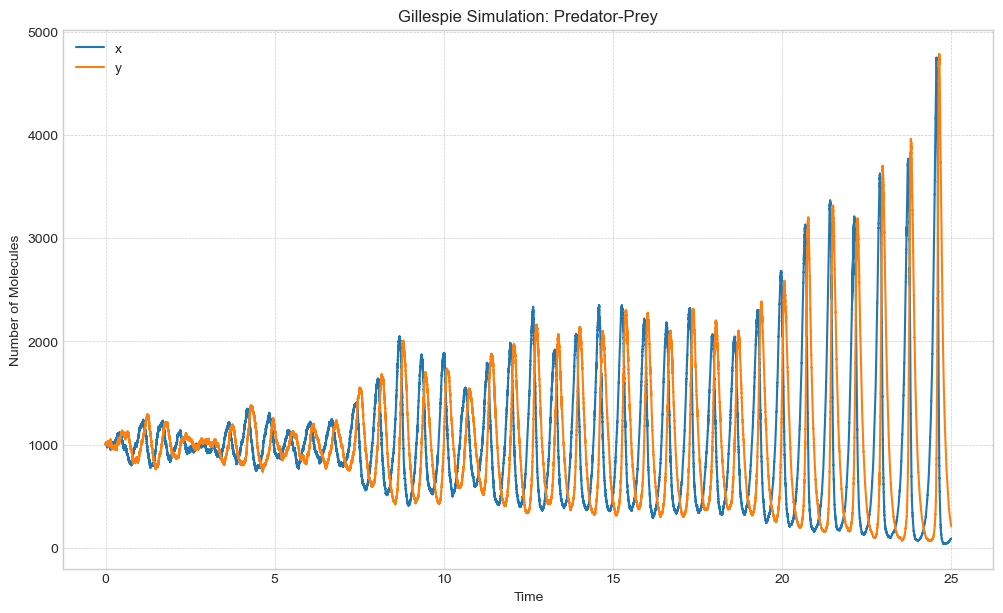

In [16]:
results = run_gillespie_simulation(
    model, 
    tmax=25, 
    use_numba=True, # Very fast!
    seed=42,  
    plot=True
)


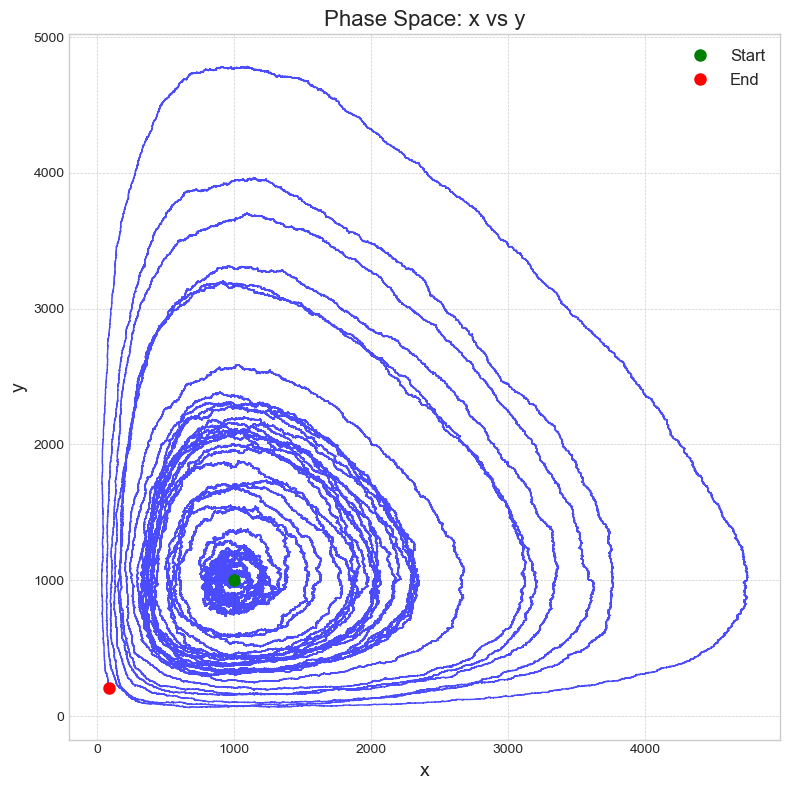

In [17]:
from pybiodynamics.visualization.plotting import plot_phase_space

plot_phase_space(results, species_x='x', species_y='y')